# Modeling 

Having fully processed my data I am now ready to begin testing model to find the best move forward with for this data set. Based on previous experience I am choosing to test decision tree, KNN, random forest, and XGBoost 

### Table of Content

1. [Load Packages](#part1) 
2. [Split, Vectorize, and Concat](#part2)
3. [Model Testing](#part3)  
    1.[Decision Tree](#part3a) 
    2.[Random Forest](#part3b) 
    3.[XGBoost](#part3c)
    4.[KNN](#part3d) 
    5.[Light Gradient Boosted Machine (LightGBM)](#part3e)
4. [Conclusion and Next Steps](#part4) 


<a name="part1"></a>
## Load Packages and Prepare Dataframe 

There are a few columns I will need to drop before train test split and I will do that here. 

In [55]:
#import packages
import pandas as pd
import numpy as np 

#Imports for plotting
from ast import literal_eval 
import pickle
import seaborn as sns
import matplotlib.pyplot as plt   
%matplotlib inline

#options
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
pd.options.display.max_rows = 50
import warnings
warnings.filterwarnings('ignore') 

#NLP Packages
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist 
from nltk import RegexpTokenizer, PorterStemmer, pos_tag  
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import string
import re   
from mpl_toolkits.mplot3d import Axes3D

# sklearn
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

# xgboost
from xgboost import XGBClassifier



In [56]:
#Load data
df = pd.read_pickle('df_processed_full.pickle')

#Preview dataset
df.head(1)

,rating_overall,employee_title_title_known,employee_title_title_unknown,employee_status_current_employee,employee_status_former_employee,employee_status_unknown_status,helpful_helpful,helpful_not_helpful,recommends_does_not_recommend,recommends_recommends,...,adv,verb,characters,tokens,words,sentences,avg_word_len,avg_sent_len,stem_str,sentiment
0,5.0,1,0,1,0,0,0,1,0,1,...,0.181818,0.181818,94,11,17,3,5.529412,5.666667,great alway room improv everybodi work togeth con love job helpfu,0.65


In [57]:
needed = ['rating_overall', 'employee_title_title_known','employee_title_title_unknown', 'employee_status_current_employee', 
          'employee_status_former_employee', 'employee_status_unknown_status', 'helpful_helpful', 'helpful_not_helpful','recommends_does_not_recommend',
          'recommends_recommends','recommends_unknown_recommends', 'area_central', 'area_east_coast','area_mountain', 'area_outside_US', 
          'area_unknown', 'area_west_coast','company_outlook_negative_outlook', 'company_outlook_neutral_outlook',
          'company_outlook_outlook_unknown', 'company_outlook_positive_outlook', 'opinion_of_CEO_approves_of_CEO', 
          'opinion_of_CEO_disapproves_of_CEO', 'opinion_of_CEO_no_opinion_of_CEO','opinion_of_CEO_unknown_opinion_of_CEO', 
           'noun', 'adj', 'adv', 'verb', 'characters','tokens', 'words', 'sentences', 'avg_word_len', 'avg_sent_len', 'stem_str', 'sentiment']

dfa = df[needed] 

<a name="part2"></a>
## Split, Vectorize, and Concat 

Now my data is ready to split into testing and training sets, vectorize the text column, and concat it back with the rest of the data set.

In [58]:
# Seperate target from features 
X = dfa.drop(columns=['rating_overall'])
y = dfa['rating_overall'] 


# Splitting data into testing and traning sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=21)

In [59]:
#Check the shae
print(X_train.shape) 
print(X_test.shape)

(2985, 36)
(11941, 36)


In [66]:
#Set up TFIDF Vectorizer using bigrams and trigrams
vectorizer = TfidfVectorizer(ngram_range=(2, 3),  # include uni and 3-rams only
                            max_df=.999, min_df=.007) 

In [67]:
#Apply Vectorizer
tfidf_data_train = vectorizer.fit_transform(X_train['stem_str'])
tfidf_data_test = vectorizer.transform(X_test['stem_str'])

In [68]:
print(tfidf_data_train.shape) 
print(tfidf_data_test.shape)

(2985, 233)
(11941, 233)


In [69]:
#Drop original text columns
X_train = X_train.drop(columns=['stem_str'])
X_test = X_test.drop(columns=['stem_str']) 
# y_train = X_train.drop(columns=['stem_str'])
# y_test = X_test.drop(columns=['stem_str'])

In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985 entries, 11454 to 5327
Data columns (total 35 columns):
employee_title_title_known               2985 non-null int64
employee_title_title_unknown             2985 non-null int64
employee_status_current_employee         2985 non-null int64
employee_status_former_employee          2985 non-null int64
employee_status_unknown_status           2985 non-null int64
helpful_helpful                          2985 non-null int64
helpful_not_helpful                      2985 non-null int64
recommends_does_not_recommend            2985 non-null int64
recommends_recommends                    2985 non-null int64
recommends_unknown_recommends            2985 non-null int64
area_central                             2985 non-null int64
area_east_coast                          2985 non-null int64
area_mountain                            2985 non-null int64
area_outside_US                          2985 non-null int64
area_unknown                       

In [71]:
#Check number of zero columns and percent
non_zero_cols = tfidf_data_train.nnz / float(tfidf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 3.5608040201005027
Percentage of columns containing 0: 0.9847175793128734


In [72]:
# Convert tfidf to array and concatenate train and test sets
X_train = pd.concat([pd.DataFrame(tfidf_data_train.toarray()), X_train.reset_index()], axis = 1)
X_test = pd.concat([pd.DataFrame(tfidf_data_test.toarray()), X_test.reset_index()], axis = 1)

<a name="part3"></a>
## Model Testing 

Below I will run decision tree, random forest, xgboost, and knn to see which one gives the best results for my data before moving on to tuning that model.

<a name="part3a"></a>
### Decision Tree

In [73]:
#Import packages
from sklearn.tree import DecisionTreeClassifier

In [74]:
#Instantiate Decision tree model
clf = DecisionTreeClassifier(criterion='entropy', random_state=23)
#Fit the model to data
clf.fit(X_train, y_train) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=23, splitter='best')

In [75]:
#Run Test Predictions
dt_test_preds = clf.predict(X_test)

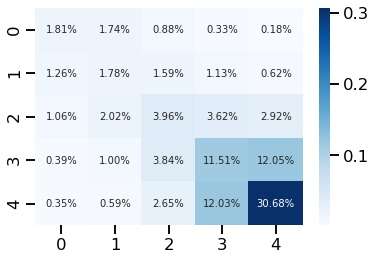

In [76]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, dt_test_preds)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues') 
plt.show()

In [77]:
#Run Metrics
dt_recall = recall_score(y_test, dt_test_preds, average='weighted')
dt_acc_score = accuracy_score(y_test, dt_test_preds)
dt_f1_score = f1_score(y_test, dt_test_preds, average='weighted')
print('Decision Tree:')
print(3*'-----')

print('Recall: {:.4}'.format(dt_recall))
print("Testing Accuracy: {:.4}".format(dt_acc_score))
print("F1 Score: {:.4}".format(dt_f1_score))

Decision Tree:
---------------
Recall: 0.4974
Testing Accuracy: 0.4974
F1 Score: 0.4974


<a name="part3b"></a>
### Random Forest

In [78]:
#Initialize Classifier 
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=23)
#Fit Classifier to Data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [79]:
#Run Test Predictions
rf_test_preds = rf_classifier.predict(X_test)

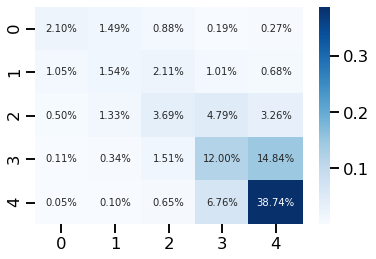

In [80]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, rf_test_preds)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues') 
plt.show()

In [81]:
#Run Metrics
rf_recall = recall_score(y_test, rf_test_preds, average='weighted')
rf_acc_score = accuracy_score(y_test, rf_test_preds)
rf_f1_score = f1_score(y_test, rf_test_preds, average='weighted')
print('Random Forest with Stematized Features:')
print(3*'-----')

print('Recall: {:.4}'.format(rf_recall))
print("Testing Accuracy: {:.4}".format(rf_acc_score))
print("F1 Score: {:.4}".format(rf_f1_score))

Random Forest with Stematized Features:
---------------
Recall: 0.5808
Testing Accuracy: 0.5808
F1 Score: 0.5598


<a name="part3c"></a>
### XGBoost

In [82]:
#Instantiate Model
xgb = XGBClassifier(random_state=23)
#Fit model to the data
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=23,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [83]:
#Run predictions
xgb_test_preds = xgb.predict(X_test)

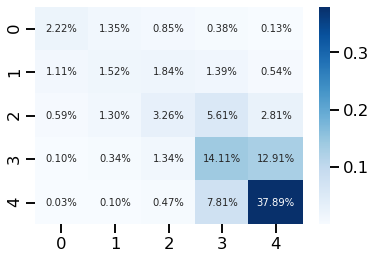

In [84]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, xgb_test_preds)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues') 
plt.show()

In [85]:
#Run metrics
xgb_recall = recall_score(y_test, xgb_test_preds, average='weighted')
xgb_acc_score = accuracy_score(y_test, xgb_test_preds)
xgb_f1_score = f1_score(y_test, xgb_test_preds, average='weighted')

print('XGBOOST:')
print(3*'-----')

print('Recall: {:.4}'.format(xgb_recall))

print("Testing Accuracy: {:.4}".format(xgb_acc_score))
print("F1 Score: {:.4}".format(xgb_f1_score))

XGBOOST:
---------------
Recall: 0.59
Testing Accuracy: 0.59
F1 Score: 0.5722


<a name="part3d"></a>
### KNN 

In [86]:
from sklearn.neighbors import KNeighborsClassifier 

#Scale X_train and X_test for knn
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [87]:
# Instantiate KNeighborsClassifier
knnc = KNeighborsClassifier()

# Fit the classifier
knnc.fit(scaled_X_train, y_train)

# Predict on the test set
knn_preds = knnc.predict(scaled_X_test)

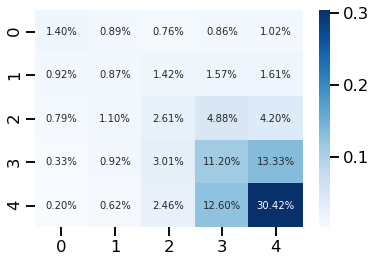

In [88]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, knn_preds)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues') 
plt.show()

In [89]:
#Run metrics
knn_recall = recall_score(y_test, knn_preds, average='weighted')
knn_acc_score = accuracy_score(y_test, knn_preds)
knn_f1_score = f1_score(y_test, knn_preds, average='weighted')

print('KNN:')
print(3*'-----')

print('Recall: {:.4}'.format(knn_recall))

print("Testing Accuracy: {:.4}".format(knn_acc_score))
print("F1 Score: {:.4}".format(knn_f1_score))

KNN:
---------------
Recall: 0.465
Testing Accuracy: 0.465
F1 Score: 0.4545


<a name="part3e"></a>
### Light Gradient Boosted Machine (LightGBM) 

In [90]:
#Import Light GBM
from lightgbm import LGBMClassifier

# define the model
lgbm = LGBMClassifier(random_state=66)

#Fit model to the data
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=66, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [91]:
#Run predictions
lgbm_test_preds = lgbm.predict(X_test)

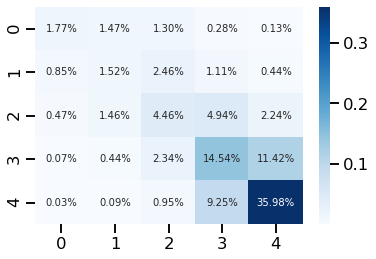

In [92]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, lgbm_test_preds)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues') 
plt.show()

In [93]:
#Run metrics
lgbm_recall = recall_score(y_test, lgbm_test_preds, average='weighted')
lgbm_acc_score = accuracy_score(y_test, lgbm_test_preds)
lgbm_f1_score = f1_score(y_test, lgbm_test_preds, average='weighted')

print('LGBM:')
print(3*'-----')

print('Recall: {:.4}'.format(lgbm_recall))

print("Testing Accuracy: {:.4}".format(lgbm_acc_score))
print("F1 Score: {:.4}".format(lgbm_f1_score))

LGBM:
---------------
Recall: 0.5827
Testing Accuracy: 0.5827
F1 Score: 0.5743


<a name="part4"></a>
## Model Refinement  
Having tested a few different models, I will now attempt to improve upon them by tuning. Since three of the models performed about the same, I will grid search those three. 


### Random Forest Random Search

In [34]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_classifier.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 23,
 'verbose': 0,
 'warm_start': False}


In [35]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 0, stop = 2000, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#
n_jobs = [-1]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap 
                }

In [37]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_classifier, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=23, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 35.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 53.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [49]:
#Initialize Classifier with best parametrs from random search
rf_rs_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                          min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                          min_impurity_split=None, bootstrap=True, n_jobs=-1, max_samples=None, random_state=23)
#Fit Classifier to Data
rf_rs_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [55]:
#Run Test Predictions
rf_best_preds = rf_rs_classifier.predict(X_test) 

#Run metrics
rfb_recall = recall_score(y_test, rf_best_preds, average='weighted')
rfb_acc_score = accuracy_score(y_test, rf_best_preds)
rfb_f1_score = f1_score(y_test, rf_best_preds, average='weighted')

print('Random Search RF:')
print(3*'-----')

print('Recall: {:.4}'.format(rfb_recall))

print("Testing Accuracy: {:.4}".format(rfb_acc_score))
print("F1 Score: {:.4}".format(rfb_f1_score))

Random Search RF:
---------------
Recall: 0.5817
Testing Accuracy: 0.5817
F1 Score: 0.558


#### Random Forest Gridsearch 

Since I did not get any results from doing a random search I will only use grid search moving foward. 

In [34]:
# create dictionary of hyperparameters to tune
param_grid = {'n_estimators': [100, 200],
              'class_weight' : ["balanced", "balanced_subsample", None],
              'max_depth': [None, 2, 10],
              'max_features': [None, 4, 16, 24],
              'min_samples_split' : [2, 3, 5, 8, 16],
              'min_samples_leaf' : [1, 3, 5, 8]
             }

# create grid search object and fit to data
grid_forest = GridSearchCV(RandomForestClassifier(random_state=23),
                           param_grid,
                           cv=2,
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1)

#fit data
grid_forest.fit(X_train, y_train)

In [36]:
#pickle grid hyperparameters
pickle_out = open("rf_grid.pickle","wb")
pickle.dump(grid_forest, pickle_out)
pickle_out.close()

In [40]:
#print best parameters
from pprint import pprint
print('Best RF Parameters:\n')
# pprint(grid_forest.get_params()) 
grid_forest.best_params_

Best RF Parameters:



{'class_weight': None,
 'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 200}

In [41]:
#Run Test Predictions
rfg_best_preds = grid_forest.predict(X_test) 

#Run metrics
rfbg_recall = recall_score(y_test, rfg_best_preds, average='weighted')
rfbg_acc_score = accuracy_score(y_test, rfg_best_preds)
rfbg_f1_score = f1_score(y_test, rfg_best_preds, average='weighted')

#print results
print('Grid Search RF:')
print(3*'-----')

print('Recall: {:.4}'.format(rfbg_recall))

print("Testing Accuracy: {:.4}".format(rfbg_acc_score))
print("F1 Score: {:.4}".format(rfbg_f1_score))

Grid Search RF:
---------------
Recall: 0.5865
Testing Accuracy: 0.5865
F1 Score: 0.5784


#### XGBoost Grid Search 

In [41]:
# create dictionary of hyperparameters to tune
param_grid = {'learning_rate': [0.1, 0.01],
              'max_depth': [None, 2, 4, 10],
              'min_child_weight': [1, 2, 3],
              'subsample': [0.5, 0.7],
              'n_estimators': [100, 200 ,300]}

# create grid search object and fit to data
grid_boost = GridSearchCV(XGBClassifier(random_state=23),
                          param_grid,
                          cv=2,
                          scoring='accuracy',
                          verbose=1,
                          n_jobs=-1)

#fit model
grid_boost.fit(X_train, y_train)

# pickle grid hyperparameters
pickle_out = open("xgb_grid.pickle","wb")
pickle.dump(grid_boost, pickle_out)
pickle_out.close()

Fitting 2 folds for each of 144 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.0min


KeyboardInterrupt: 

In [ ]:
#print best parameters
from pprint import pprint
print('Best XGB Parameters:\n')
grid_boost.best_params_

In [ ]:
#Run Test Predictions
xgbb_best_preds = grid_boost.predict(X_test) 

#Run metrics
xgbb_recall = recall_score(y_test, xgbb_best_preds, average='weighted')
xgbb_acc_score = accuracy_score(y_test, xgbb_best_preds)
xgbb_f1_score = f1_score(y_test, xgbb_best_preds, average='weighted')

#print results
print('Grid Search XGB:')
print(3*'-----')

print('Recall: {:.4}'.format(xgbb_recall))

print("Testing Accuracy: {:.4}".format(xgbb_acc_score))
print("F1 Score: {:.4}".format(xgbb_f1_score))

#### LGBM Grid Search 

In [37]:
# create dictionary of hyperparameters to tune
param_grid = {'n_estimators': [100, 200],
                'colsample_bytree': [0.7, 0.8],
                'max_depth': [15, 20],
                'num_leaves': [50, 100, 200],
                'min_split_gain': [0.3,0.4],
                'reg_alpha': [1.0, 1.1],
                'reg_lambda': [1.45, 1.5],
                'subsample': [0.7, 0.75],
                'subsample_freq': [20]
               }

# create grid search object and fit to data
grid_lgbm = GridSearchCV(lgbm,
                        param_grid,
                        cv=2,
                        scoring='accuracy',
                        verbose=1,
                        n_jobs=-1,
                        error_score=0)

#fit model
grid_lgbm.fit(X_train, y_train)

# pickle grid hyperparameters
pickle_out = open("lgbm_grid.pickle","wb")
pickle.dump(grid_lgbm, pickle_out)
pickle_out.close()

Fitting 2 folds for each of 384 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 15.8min finished


In [39]:
#print best parameters
from pprint import pprint
print('Best LGBM Parameters:\n')
grid_lgbm.best_params_

Best LGBM Parameters:



{'colsample_bytree': 0.7,
 'max_depth': 15,
 'min_split_gain': 0.4,
 'n_estimators': 100,
 'num_leaves': 50,
 'reg_alpha': 1.0,
 'reg_lambda': 1.5,
 'subsample': 0.7,
 'subsample_freq': 20}

In [40]:
#Run Test Predictions
lgbmb_best_preds = grid_lgbm.predict(X_test) 

#Run metrics
lgbmb_recall = recall_score(y_test, lgbmb_best_preds, average='weighted')
lgbmb_acc_score = accuracy_score(y_test, lgbmb_best_preds)
lgbmb_f1_score = f1_score(y_test, lgbmb_best_preds, average='weighted')

#print results
print('Grid Search LGBM:')
print(3*'-----')

print('Recall: {:.4}'.format(lgbmb_recall))

print("Testing Accuracy: {:.4}".format(lgbmb_acc_score))
print("F1 Score: {:.4}".format(lgbmb_f1_score))

Grid Search LGBM:
---------------
Recall: 0.5771
Testing Accuracy: 0.5771
F1 Score: 0.5678


In [42]:
# load grid hyperparameters

grid_forest = pd.read_pickle('rf_grid.pickle')
grid_boost = pd.read_pickle('xgb_grid.pickle')
grid_lgbm = pd.read_pickle('lgbm_grid.pickle')

In [46]:

"""random forest"""
# print random forest hyperparameters
# print("Random Forest:",
#       f"num estimators = {grid_forest.best_params_['n_estimators']},",
#       #f"criterion = {grid_forest.best_params_['criterion']},",
#       f"max depth = {grid_forest.best_params_['max_depth']},",
#       f"max features = {grid_forest.best_params_['max_features']}")

# instantiate random forest classifier
rf_classifier = RandomForestClassifier(#criterion=grid_forest.best_params_['criterion'],
                                       max_depth=grid_forest.best_params_['max_depth'],
                                       max_features=grid_forest.best_params_['max_features'],
                                       n_estimators=grid_forest.best_params_['n_estimators'],
                                       class_weight=grid_forest.best_params_['class_weight'],
                                       min_samples_leaf=grid_forest.best_params_['min_samples_leaf'],
                                       min_samples_split=grid_forest.best_params_['min_samples_split'], 
                                       random_state=42)

# fit and predict on random forest classifier
rf_classifier.fit(X_train, y_train)
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)

In [47]:

"""xgboost"""
# print xgboost hyperparameters
# print("XGBoost:",
#       f"learning rate = {grid_boost.best_params_['learning_rate']},",
#       f"max depth = {grid_boost.best_params_['max_depth']},",
#       f"min child weight = {grid_boost.best_params_['min_child_weight']},",
#       f"subsample = {grid_boost.best_params_['subsample']},",
#       f"num estimators = {grid_boost.best_params_['n_estimators']}")

# instantiate xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=grid_boost.best_params_['learning_rate'],
                               max_depth=grid_boost.best_params_['max_depth'],
                               min_child_weight=grid_boost.best_params_['min_child_weight'],
                               subsample=grid_boost.best_params_['subsample'],
                               n_estimators=grid_boost.best_params_['n_estimators'],
                               random_state=42)

# fit and predict on xgboost classifier
xgb_classifier.fit(X_train, y_train)
xgb_train_preds = xgb_classifier.predict(X_train)
xgb_test_preds = xgb_classifier.predict(X_test)

In [49]:

"""LightGBM"""

# print LightGBM hyperparameters
# print("LightGBM:",
#       f"n_estimators = {grid_log.best_params_['n_estimators']},",
#       f"boosting = {grid_log.best_params_['boosting']}",
#       f"colsample_bytree = {grid_log.best_params_['colsample_bytree']}",
#       f"max_depth = {grid_log.best_params_['max_depth']}",
#       f"num_leaves = {grid_log.best_params_['num_leaves']}",
#       f"min_split_gain = {grid_log.best_params_['min_split_gain']}",
#       f"colsample_bytree = {grid_log.best_params_['colsample_bytree']}")  

# instantiate LogReg classifier
grid_lgbm_classifier = LGBMClassifier(
                               n_estimators = grid_lgbm.best_params_['n_estimators'],
                               colsample_bytree = grid_lgbm.best_params_['colsample_bytree'], 
                               max_depth = grid_lgbm.best_params_['max_depth'],
                               num_leaves = grid_lgbm.best_params_['num_leaves'], 
                               min_split_gain = grid_lgbm.best_params_['min_split_gain'], 
                               reg_alpha = grid_lgbm.best_params_['reg_alpha'],
                               reg_lambda = grid_lgbm.best_params_['reg_lambda'], 
                               subsample = grid_lgbm.best_params_['subsample'], 
                               subsample_freq = grid_lgbm.best_params_['subsample_freq'],  
                              random_state = 42)

# fit and predict on logreg classifier
grid_lgbm_classifier.fit(X_train, y_train)
lgbm_train_preds = grid_lgbm_classifier.predict(X_train)
lgbm_test_preds = grid_lgbm_classifier.predict(X_test)

In [53]:
def metrics(train_preds, y_train, test_preds, y_test):
    
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")

    print(f"Training Precision:\t{precision_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds, average='weighted'):.4}")

    print(f"Training Recall:\t{recall_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds, average='weighted'):.4}")

    print(f"Training F1:\t\t{f1_score(y_train, train_preds, average='weighted'):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds, average='weighted'):.4}")

In [54]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

# using function metrics from utils file

print('RANDOM FOREST: \n')
metrics(rf_train_preds, y_train, rf_test_preds, y_test)

print('\n\nXGBOOST: \n')
metrics(xgb_train_preds, y_train, xgb_test_preds, y_test)

print('\n\nLightGBM: \n')
metrics(lgbm_train_preds, y_train, lgbm_test_preds, y_test)

RANDOM FOREST: 

Training Accuracy:	0.8141 	Testing Accuracy:	0.5809
Training Precision:	0.814 	Testing Precision:	0.5707
Training Recall:	0.8141 	Testing Recall:		0.5809
Training F1:		0.8104 	Testing F1:		0.573


XGBOOST: 

Training Accuracy:	0.6814 	Testing Accuracy:	0.5848
Training Precision:	0.6798 	Testing Precision:	0.5598
Training Recall:	0.6814 	Testing Recall:		0.5848
Training F1:		0.6672 	Testing F1:		0.5632


LightGBM: 

Training Accuracy:	0.8844 	Testing Accuracy:	0.5851
Training Precision:	0.8845 	Testing Precision:	0.5708
Training Recall:	0.8844 	Testing Recall:		0.5851
Training F1:		0.8833 	Testing F1:		0.576


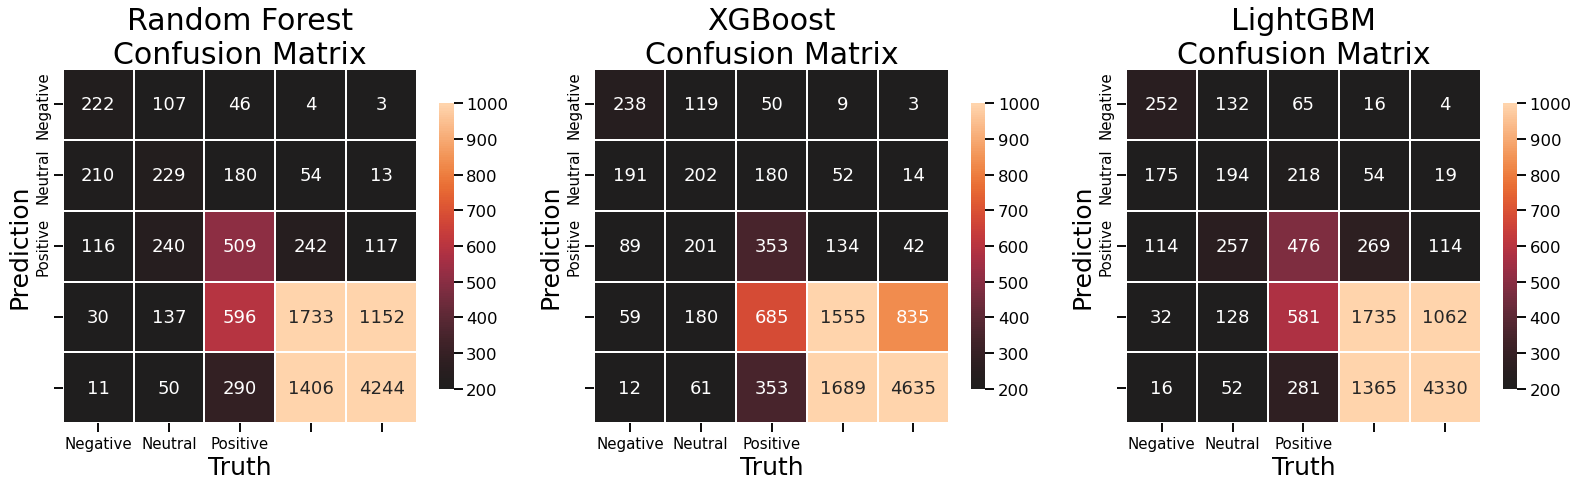

In [52]:
sns.color_palette("bright")
sns.set_context("talk")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(27, 7))


"""random forest"""
# plot random forest confusion matrix
sns.heatmap(confusion_matrix(y_test, rf_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
### Evaluate model metrics
            ax=ax[0]).set_title('Random Forest\nConfusion Matrix', fontsize=30)

ax[0].set_xlabel('Truth', fontsize=25)
ax[0].set_ylabel('Prediction', fontsize=25)
ax[0].set_xticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15)
ax[0].set_yticklabels(['Negative', 'Neutral', 'Positive'], va='center', fontsize=15)


"""xgboost"""
# plot xgboost confusion matrix
sns.heatmap(confusion_matrix(y_test, xgb_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
            ax=ax[1]).set_title('XGBoost\nConfusion Matrix', fontsize=30)

ax[1].set_xlabel('Truth', fontsize=25)
ax[1].set_ylabel('Prediction', fontsize=25)
ax[1].set_xticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15)
ax[1].set_yticklabels(['Negative', 'Neutral', 'Positive'], va='center', fontsize=15)


"""LMGB"""
# plot LightGBM confusion matrix

sns.heatmap(confusion_matrix(y_test, lgbm_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
            ax=ax[2]).set_title('LightGBM\nConfusion Matrix', fontsize=30)

ax[2].set_xlabel('Truth', fontsize=25)
ax[2].set_ylabel('Prediction', fontsize=25)
ax[2].set_xticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15)
ax[2].set_yticklabels(['Negative', 'Neutral', 'Positive'], va='center', fontsize=15)


plt.savefig(fname='../images/conf_mtrx', bbox_inches='tight', pad_inches=.1)
plt.show()

<a name="part5"></a>
## Conclusion 

In the end my best model was XGBoost with 59% accuracy. This indicates it was able to accurately classify reviews 59% percent of the time. This indicates that machine learning could be a better way to score company reviews and this the overall company rating versus relying on a self reported score. For my next steps I will try to improve on my two best models using grid search to see if I can improve accuracy scores. 